#### Описание данных

Данные предоставляются в формате JSON на каждой строке следующего содержания:

*   word – таргет (слово, которое хотел ввести пользователь)
*   curve
    *   x – массив координат X
    *   y – массив координат Y
    *   t – массив временных меток (время в миллисекундах)
    *   grid – формат раскладким
        *   grid\_name – название раскладки (default или extra)
        *   width – ширина раскладки
        *   height – высота раскладки
        *   keys – массив клавиш
            *   label – символ клавиши
            *   hitbox – область нажатия
                *   x – координата X верхнего левого угла
                *   y – координата Y верхнего левого угла
                *   w – ширина области
                *   h – высота области

У клавиш `enter`, `space`, `globe`, `toNumberState`, `backspace` нет ключа 'label', но есть одноименный ключ 'action'

* Кажется, из многих оюучающих примеров для default клавиатуры можно "деформировав пространство" сделать обучающие примеры для extra клавиатуры.
    * Интересно, нужно ли будет также деформировать время


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List, Set, Optional, Dict
from collections import defaultdict
import json
import os

from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
ORIGINAL_TRAIN_DATASET_PATH = "../../data/data_original/train.jsonl"
TRAIN_DATASET_PATH = "../../data/data_preprocessed/train_filtered.jsonl"
VALID_DATASET_PATH = "../../data/data_preprocessed/valid.jsonl"
TEST_DATASET_PATH = "../../data/data_preprocessed/test.jsonl"

VOCAB_PATH = "../../data/data_preprocessed/voc.txt"
GRIDS_PATH = "../../data/data_preprocessed/gridname_to_grid.json"

In [4]:
with open(ORIGINAL_TRAIN_DATASET_PATH, 'rb') as f:
    n_train_lines = sum(1 for _ in f)
print(n_train_lines)
# result: 6000000
# takes 90 seconds

6000000


In [5]:
with open(TRAIN_DATASET_PATH, 'rb') as f:
    n_train_lines = sum(1 for _ in f)
print(n_train_lines)
# result: 5591814
# takes 15 seconds

5591814


In [6]:
N_TRAIN_LINES = 6_000_000  # 5_591_814 for the filtered version
N_VAL_LINES = N_TEST_LINES = 10_000

# Vocab

The vocabulary contains the `-` symbol and all Russian lanuage lowercase letters except for `ё`.

Thus, the decoder must be able to predict all Russian letters (except for `ё`) and also ["-", "\<eos>", "\<pad>, "\<sos>"]

* pad does not need to be generated, but it must be tokenized: it's id has to be passed as the value of ignore\_index argument in CrossEntropyLoss.
* sos should never be generated, but it must be tokenized, as it will be used as the initial token (embedding is needed).

In [7]:
from typing import Set


def get_unique_chars(vocab_path: str) -> Set[str]:
    """Given a path to vocabulary returns a set of unique characters in it"""
    with open(vocab_path, encoding="utf-8") as f:
        vocab = f.read()
    return set(vocab)

In [8]:
voc = get_unique_chars(VOCAB_PATH)

In [9]:
print(sorted(list(voc)))

['\n', '-', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


In [10]:
'ё' in voc



False

In [11]:
import numpy as np
def get_max_output_len(vocab_path: str):
    """Given a path to vocabulary returns a maximum length of output sequence"""
    with open(vocab_path, encoding="utf-8") as f:
        vocab_str = f.read()
    vocab = vocab_str.split('\n')
    return vocab, np.argmax(np.array([len(word) for word in vocab])), max([len(word) for word in vocab])

In [12]:
vocab, argmax_word_len, max_word_len = get_max_output_len(VOCAB_PATH)

In [13]:
max_word_len

34

In [14]:
vocab[argmax_word_len]

'информационно-телекоммуникационной'

In [15]:
max_seq_len = max_word_len + 2  # with start and end tokens

In [16]:
if '\n' in voc:
    voc.remove('\n')

In [17]:
n_tokens = len(voc) + 2  # with start and end tokens

In [18]:
n_tokens, max_seq_len

(35, 36)

In [19]:
def get_word_len_to_count(dataset_path: str, 
                          total: Optional[int] = None) -> Dict[int, int]:
    """
    Given a path to dataset returns a dictionary with 
    word lengths as keys and their counts as values.
    """
    word_len_to_count = defaultdict(int)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total=total):
            data = json.loads(line)
            word = data['word']
            word_len_to_count[len(word)] += 1
    return word_len_to_count

In [20]:
train_word_len_counts = get_word_len_to_count(TRAIN_DATASET_PATH, total=N_TRAIN_LINES)
val_word_len_counts = get_word_len_to_count(VALID_DATASET_PATH, total=N_VAL_LINES)

100%|██████████| 10000/10000 [00:00<00:00, 27097.53it/s]


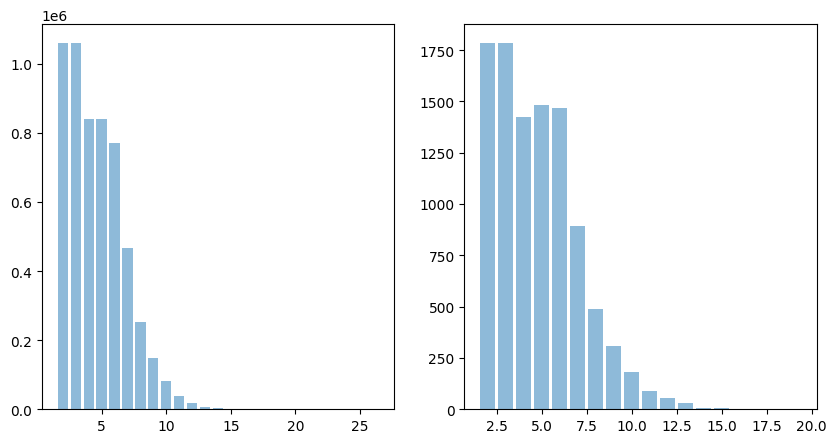

In [21]:
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(10)
fig.set_figheight(5)

train_ax.bar(train_word_len_counts.keys(), train_word_len_counts.values(), alpha=0.5, label='train')
val_ax.bar(val_word_len_counts.keys(), val_word_len_counts.values(), alpha=0.5, label='val')

plt.show()

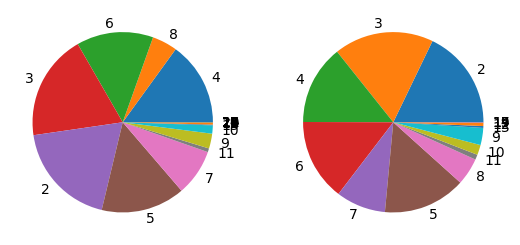

In [22]:
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)


train_ax.pie(train_word_len_counts.values(), labels = train_word_len_counts.keys())
val_ax.pie(val_word_len_counts.values(), labels = val_word_len_counts.keys()) 
plt.show()

In [23]:
train_word_len_counts_tuples = sorted([(l, n) for l, n in train_word_len_counts.items()])
val_word_len_counts_tuples = sorted([(l, n) for l, n in val_word_len_counts.items()])

In [24]:
def get_word_len_percentages(word_len_counts_tuples) -> Dict[int, float]:
    n_lines = sum([cnt for wrd_len, cnt in word_len_counts_tuples])
    return {wrd_len: cnt/n_lines*100 for wrd_len, cnt in word_len_counts_tuples}

In [25]:
def get_cumulative_prob_word_len(word_len_prcntg: Dict[int, float], 
                                 limit: int) -> float:
    cumulative_prob = 0
    for wrd_len, prcntg in word_len_prcntg.items():
        if wrd_len <= limit:
            cumulative_prob += prcntg
    return cumulative_prob

In [26]:
train_word_len_prcntg = get_word_len_percentages(train_word_len_counts_tuples)
train_word_len_prcntg

{2: 18.956764298669448,
 3: 18.985216604128823,
 4: 15.016558133013724,
 5: 15.043830141703568,
 6: 13.768698315072712,
 7: 8.339690840932835,
 8: 4.52638446128573,
 9: 2.6617659314133126,
 10: 1.4753530786252904,
 11: 0.6735381398594446,
 12: 0.3309838274305977,
 13: 0.1376476399250762,
 14: 0.05091371064917396,
 15: 0.02095920930131081,
 16: 0.006831414635751476,
 17: 0.0024678932453761873,
 18: 0.0015200791728766372,
 19: 0.00042919882528281517,
 20: 0.00019671612825462363,
 21: 0.00016094955948105572,
 22: 3.576656877356793e-05,
 24: 3.576656877356793e-05,
 26: 1.7883284386783967e-05}

In [27]:
val_word_len_prcntg = get_word_len_percentages(val_word_len_counts_tuples)
val_word_len_prcntg

{2: 17.84,
 3: 17.87,
 4: 14.24,
 5: 14.82,
 6: 14.66,
 7: 8.91,
 8: 4.88,
 9: 3.0700000000000003,
 10: 1.7999999999999998,
 11: 0.91,
 12: 0.5499999999999999,
 13: 0.33,
 14: 0.04,
 15: 0.06,
 17: 0.01,
 19: 0.01}

Распределения похожи. В обоих датасетах есть очен длииные слова (порядка 20 букв), однако, слова не длинне 11 букв составляют 99%, а слова не длиннее 7 букв составляют 88%

In [28]:
round(
    get_cumulative_prob_word_len(train_word_len_prcntg, 11), 2)

99.45

In [29]:
round(
    get_cumulative_prob_word_len(val_word_len_prcntg, 11), 2)

99.0

In [30]:
def get_word_len_pie_chart_dict(word_len_prcntg: Dict[int, float], 
                                limit: int
                                ) -> Dict[str, float]:
    word_len_pychart_dict = {}

    ommited_range = [float('inf'), limit]
    ommited_cumulative_prcntg = 0

    for word_len, prcntg in word_len_prcntg.items():
        if word_len <= limit:
            word_len_pychart_dict[f"{word_len}"] = prcntg
        else:
            ommited_cumulative_prcntg += prcntg
            if word_len < ommited_range[0]:
                ommited_range[0] = word_len
            if word_len > ommited_range[1]:
                ommited_range[1] = word_len

    word_len_pychart_dict[f"({ommited_range[0]}-{ommited_range[1]})"] = ommited_cumulative_prcntg

    return word_len_pychart_dict

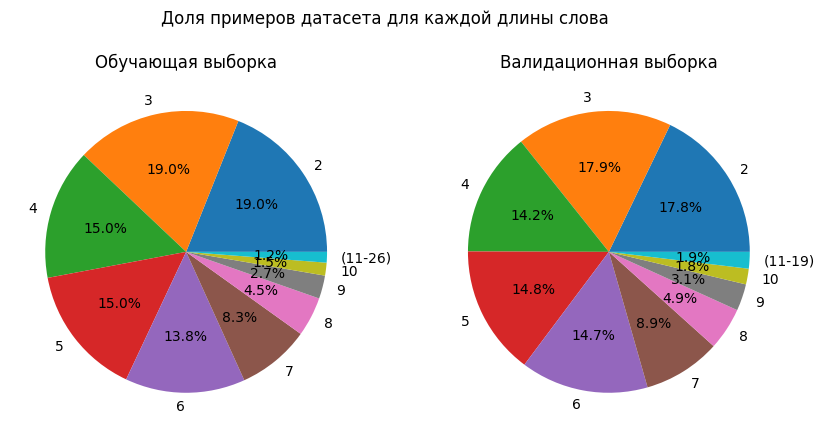

In [31]:
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(10)
fig.set_figheight(5)

fig.suptitle('Доля примеров датасета для каждой длины слова')

limit = 10

train_word_len_pychart_dict = get_word_len_pie_chart_dict(train_word_len_prcntg, limit)
val_word_len_pychart_dict = get_word_len_pie_chart_dict(val_word_len_prcntg, limit)

train_ax.pie(train_word_len_pychart_dict.values(), labels = train_word_len_pychart_dict.keys(), autopct='%1.1f%%')
train_ax.set_title('Обучающая выборка')

val_ax.pie(val_word_len_pychart_dict.values(), labels = val_word_len_pychart_dict.keys(), autopct='%1.1f%%')
val_ax.set_title('Валидационная выборка')


plt.show()

In [32]:
# from typing import List, Optional

# def get_trj_seq_lens(dataset_path: str, total: Optional[int] = None):
#     """Given a path to dataset returns a list of trajectory lengths"""
#     seq_lens = []
#     with open(dataset_path, encoding="utf-8") as f:
#         for line in tqdm(f, total = total):
#             line_data = json.loads(line)
#             trj_len = len(line_data['curve']['x'])
#             seq_lens.append(trj_len)
#     return seq_lens
            

In [33]:
def get_traj_len_to_count(dataset_path: str, total: Optional[int] = None) -> Dict[int, int]:
    """Given a path to dataset returns a dictionary where keys are trajectory lengths and values are their counts"""
    traj_len_to_count = defaultdict(int)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            trj_len = len(line_data['curve']['x'])
            traj_len_to_count[trj_len] += 1
    return traj_len_to_count

In [34]:
train_traj_len_to_count = get_traj_len_to_count(TRAIN_DATASET_PATH, total = 6_000_000)
val_traj_len_to_count = get_traj_len_to_count(VALID_DATASET_PATH, total = 10_000)
test_traj_len_to_count = get_traj_len_to_count(TEST_DATASET_PATH, total = 10_000)

100%|██████████| 10000/10000 [00:00<00:00, 34641.88it/s]


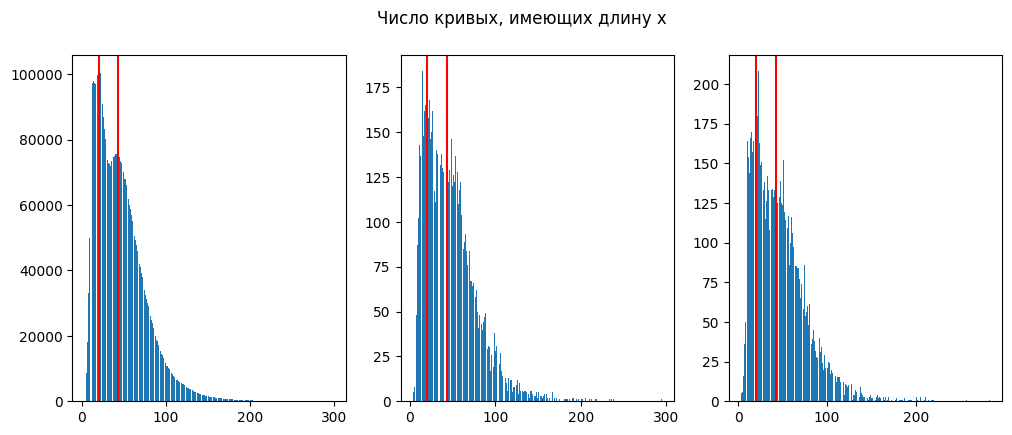

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=3)

fig.set_figwidth(12)
fig.set_figheight(4.5)
fig.suptitle('Число кривых, имеющих длину x')

traj_len_to_count_list = [
    train_traj_len_to_count,
    val_traj_len_to_count,
    test_traj_len_to_count
]

for i, traj_len_to_count in enumerate(traj_len_to_count_list):
    axs[i].bar(traj_len_to_count.keys(), traj_len_to_count.values())
    train_ax.set_title('Обучающая выборка')

    axs[i].axvline(x = 20, color = 'r', linestyle = '-') 
    axs[i].axvline(x = 43, color = 'r', linestyle = '-') 

plt.show()


Распределения выше имеют две моды

In [36]:
train_seq_lens = list(train_traj_len_to_count.keys())
val_seq_lens = list(val_traj_len_to_count.keys())
test_seq_lens = list(test_traj_len_to_count.keys())

In [37]:
max(train_seq_lens), max(val_seq_lens), max(test_seq_lens)

(299, 294, 283)

In [38]:
min(train_seq_lens), min(val_seq_lens), min(test_seq_lens)

(4, 4, 4)

In [39]:
def get_word_to_count(dataset_path: str, total: Optional[int] = None) -> Dict[str, int]:
    """Given a path to dataset returns a dictionary where keys are words and values are their counts"""
    word_to_count = defaultdict(int)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            word = line_data['word']
            word_to_count[word] += 1
    return word_to_count

In [40]:
train_word_to_count = get_word_to_count(TRAIN_DATASET_PATH, total = 6_000_000)
val_word_to_count = get_word_to_count(VALID_DATASET_PATH, total = 10_000)

100%|██████████| 10000/10000 [00:00<00:00, 18950.92it/s]


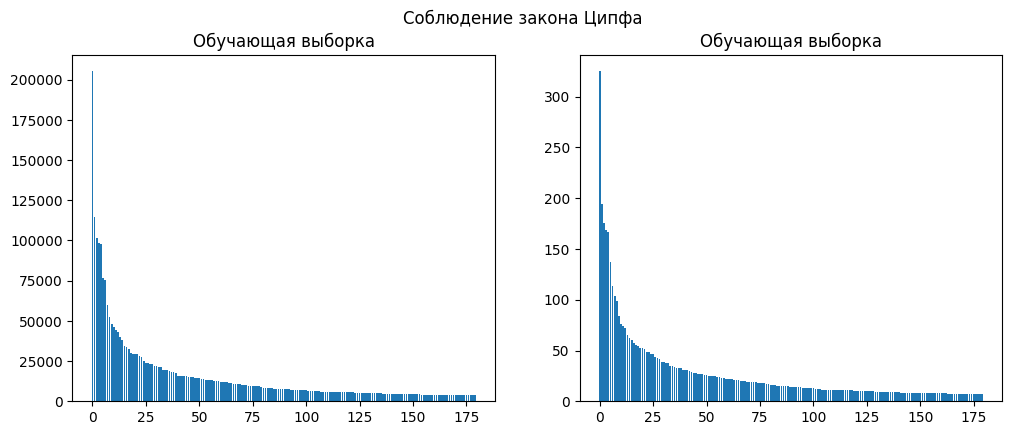

In [41]:
n_elements = 180  # If we take more elements, the line in the beginning will be ivisible
_range = range(n_elements)
ziph_train = sorted(list(train_word_to_count.values()), reverse=True)[:n_elements]
ziph_val = sorted(list(val_word_to_count.values()), reverse=True)[:n_elements]


fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Соблюдение закона Ципфа')


fig.set_figwidth(12)
fig.set_figheight(4.5)

train_ax.bar(_range, ziph_train)
train_ax.set_title('Обучающая выборка')
val_ax.bar(_range, ziph_val)
val_ax.set_title('Обучающая выборка')

plt.show()

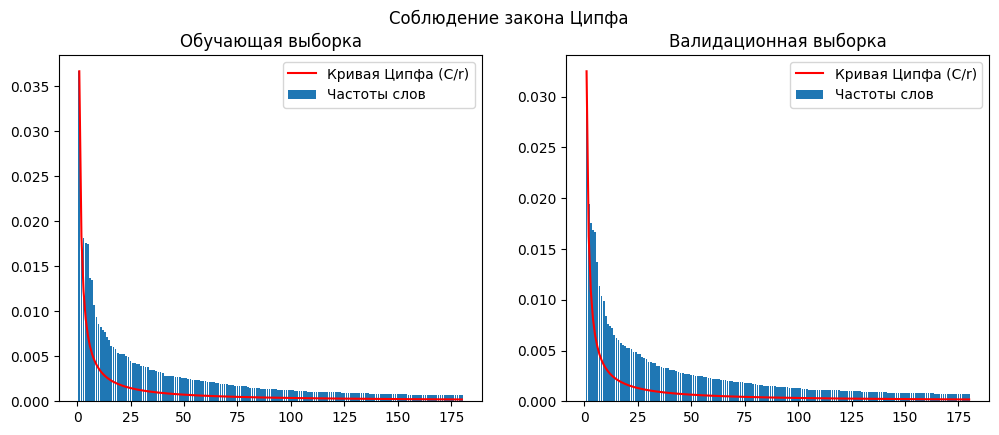

In [42]:
import matplotlib.pyplot as plt

# Задание количества элементов
n_elements = 180
_range = range(1, n_elements+1)

# Получение частотностей слов и нормализация
train_word_frequencies = sorted(list(train_word_to_count.values()), reverse=True)[:n_elements]
val_word_frequencies = sorted(list(val_word_to_count.values()), reverse=True)[:n_elements]

train_total_words = sum(train_word_to_count.values())
val_total_words = sum(val_word_to_count.values())

ziph_train = [freq / train_total_words for freq in train_word_frequencies]
ziph_val = [freq / val_total_words for freq in val_word_frequencies]

# Расчет нормализующего коэффициента C для кривой Ципфа
C_train = ziph_train[0]
C_val = ziph_val[0]

# Построение графиков
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Соблюдение закона Ципфа')

fig.set_figwidth(12)
fig.set_figheight(4.5)



train_ax.bar(_range, ziph_train, label='Частоты слов')
train_ax.plot(_range, [C_train / r for r in _range], color='red', label='Кривая Ципфа (C/r)')
train_ax.set_title('Обучающая выборка')
train_ax.legend()

val_ax.bar(_range, ziph_val, label='Частоты слов')
val_ax.plot(_range, [C_val / r for r in _range], color='red', label='Кривая Ципфа (C/r)')
val_ax.set_title('Валидационная выборка')
val_ax.legend()

plt.show()


C_val, b_val, alpha_val = (0.0716340072944351, 1.7170845165588056, 0.8524520793114589)
C_train, b_train, alpha_train = (0.07040948522422054, 1.3229076529534576, 0.8504737452068405)
C, b, alpha = (0.07102174625932782, 1.5199960847561316, 0.8514629122591497)


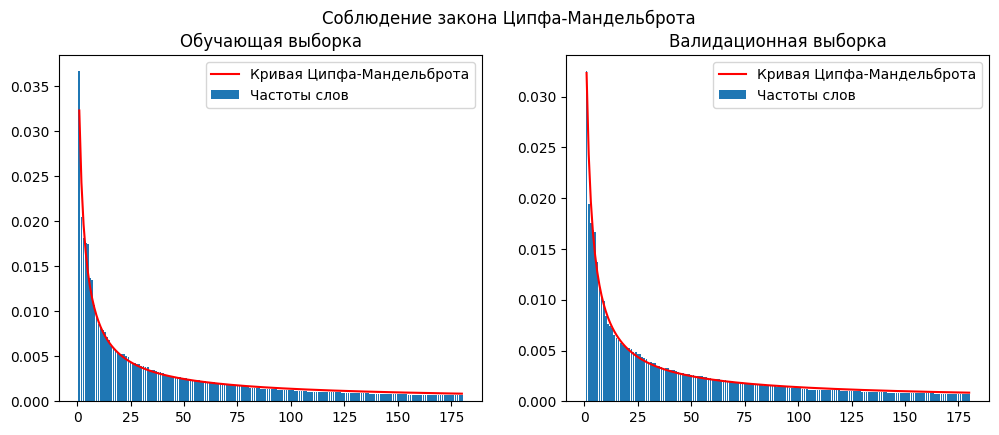

In [43]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Задание количества элементов
n_elements = 180
_range = np.arange(1, n_elements + 1)

# Получение частотностей слов и нормализация
train_word_frequencies = sorted(list(train_word_to_count.values()), reverse=True)[:n_elements]
val_word_frequencies = sorted(list(val_word_to_count.values()), reverse=True)[:n_elements]

train_total_words = sum(train_word_to_count.values())
val_total_words = sum(val_word_to_count.values())

ziph_train = [freq / train_total_words for freq in train_word_frequencies]
ziph_val = [freq / val_total_words for freq in val_word_frequencies]

# Функция закона Ципфа-Мандельброта
def zipf_mandelbrot_law(rank, C, b, alpha):
    return C / (rank + b) ** alpha

# Подбор коэффициентов для обучающей выборки
train_ziph_coefs, _ = curve_fit(zipf_mandelbrot_law, _range, ziph_train, p0=[1, 1, 1])
C_train, b_train, alpha_train = train_ziph_coefs

# Подбор коэффициентов для валидационной выборки
val_ziph_coefs, _ = curve_fit(zipf_mandelbrot_law, _range, ziph_val, p0=[1, 1, 1])
C_val, b_val, alpha_val = val_ziph_coefs

# конечные коэффициенты
C, b, alpha = map(lambda x: (x[0]+x[1])/2, zip(train_ziph_coefs, val_ziph_coefs))

# Построение графиков
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Соблюдение закона Ципфа-Мандельброта')

fig.set_figwidth(12)
fig.set_figheight(4.5)

train_ax.bar(_range, ziph_train, label='Частоты слов')
train_ax.plot(_range, zipf_mandelbrot_law(_range, C, b, alpha), color='red', label='Кривая Ципфа-Мандельброта')
train_ax.set_title('Обучающая выборка')
train_ax.legend()

val_ax.bar(_range, ziph_val, label='Частоты слов')
val_ax.plot(_range, zipf_mandelbrot_law(_range, C, b, alpha), color='red', label='Кривая Ципфа-Мандельброта')
val_ax.set_title('Валидационная выборка')
val_ax.legend()

print(f"{C_val, b_val, alpha_val = }")
print(f"{C_train, b_train, alpha_train = }")
print(f"{C, b, alpha = }")

plt.show()


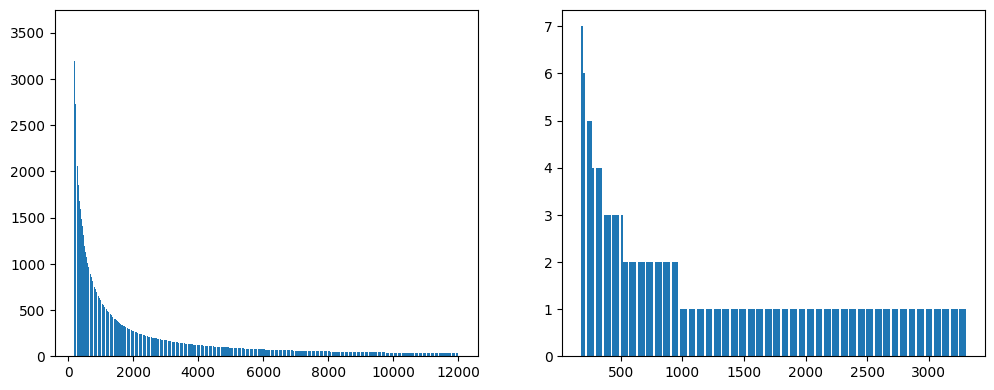

In [44]:
# n_elements = 180  # If we take more elements, the line in the beginning will be ivisible
_range_train = list(range(180, 12000))
_range_val = list(range(180, 3300))

ziph_train = sorted(list(train_word_to_count.values()), reverse=True)[_range_train[0]:_range_train[-1]+1]
ziph_val = sorted(list(val_word_to_count.values()), reverse=True)[_range_val[0]:_range_val[-1]+1]


fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(12)
fig.set_figheight(4.5)

train_ax.bar(_range_train, ziph_train)
val_ax.bar(_range_val, ziph_val)
plt.show()

In [45]:
ziph_train = sorted(list(train_word_to_count.values()), reverse=True)[_range_train[0]:_range_train[-1]]
ziph_val = sorted(list(val_word_to_count.values()), reverse=True)[_range_val[0]:_range_val[-1]]

In [46]:
len(ziph_train)

11819

In [47]:
N_WORDS_IN_VOCAB = 500_000

covered_words_fraction = len(train_word_to_count) / N_WORDS_IN_VOCAB

print(f"Словарь покрыт тренировочным датасетом на {covered_words_fraction:.3%}")


Словарь покрыт тренировочным датасетом на 27.465%


In [48]:
# print most popular words

tupled_train_word_to_count = [(word, count) for word, count in train_word_to_count.items()]
tupled_train_word_to_count_sorted = sorted(tupled_train_word_to_count, key=lambda x: x[1], reverse=True)

print(*tupled_train_word_to_count_sorted[:100], sep='\n')

('не', 205166)
('ты', 114308)
('что', 101587)
('да', 98626)
('на', 97746)
('как', 76658)
('ну', 75634)
('это', 60007)
('все', 52253)
('нет', 48164)
('так', 45959)
('мне', 44445)
('меня', 42986)
('привет', 40012)
('тебя', 37908)
('то', 34096)
('хорошо', 33726)
('ок', 32430)
('еще', 30042)
('тебе', 29464)
('по', 29373)
('там', 29083)
('за', 28067)
('уже', 27755)
('вот', 25209)
('он', 24022)
('тоже', 23490)
('че', 23301)
('надо', 23041)
('но', 22196)
('есть', 22097)
('же', 21542)
('если', 21395)
('где', 19705)
('или', 19690)
('спасибо', 19314)
('мы', 18755)
('она', 17954)
('будет', 17918)
('только', 17725)
('когда', 15769)
('завтра', 15753)
('до', 15702)
('бы', 15548)
('знаю', 15450)
('ага', 14986)
('можно', 14958)
('хочу', 14885)
('просто', 14697)
('сейчас', 14589)
('сегодня', 14408)
('ладно', 14004)
('буду', 13686)
('пока', 13340)
('вы', 13328)
('кто', 13225)
('дома', 12976)
('для', 12694)
('давай', 12542)
('от', 12496)
('может', 12235)
('почему', 12080)
('тут', 11859)
('понятно', 11748

In [49]:
def get_word_len_to_swipe_lens(dataset_path: str, total: Optional[int] = None) -> Dict[int, List[int]]:
    """Given a path to dataset returns a dictionary where keys are word lengths and values are lists of swipe lengths"""
    word_len_to_swipe_len = defaultdict(list)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            word = line_data['word']
            swipe_len = len(line_data['curve']['x'])
            word_len_to_swipe_len[len(word)].append(swipe_len)
    return word_len_to_swipe_len

In [50]:
train_word_len_to_swipe_lens = get_word_len_to_swipe_lens(TRAIN_DATASET_PATH, total = N_TRAIN_LINES)
val_word_len_to_swipe_len = get_word_len_to_swipe_lens(VALID_DATASET_PATH, total = N_VAL_LINES)

100%|██████████| 10000/10000 [00:00<00:00, 21966.95it/s]


In [51]:
# def plot_word_len_to_swipe_len_lst(word_len_to_swipe_len_lst: List[Dict[int, List[int]]],
#                                    titles: Optional[List[str]] = None
#                                    ) -> None:
#     if titles is None:
#         titles = ['' for _ in word_len_to_swipe_len_lst]
#     assert len(titles) == len(word_len_to_swipe_len_lst)
    
#     fig, axs = plt.subplots(nrows=1, ncols=len(word_len_to_swipe_len_lst))
#     # ! In that case word_len_to_swipe_len_lst is of type axes 
#     # instaed of a numpy array of axes. May be better check
#     # ```if isinstance(word_len_to_swipe_len_lst, matplotlib.axes._axes.Axes):``` 
#     if len(word_len_to_swipe_len_lst) == 1:  
#         axs = [axs]
#     fig.set_figwidth(12)
#     fig.set_figheight(5)
#     fig.suptitle('')

#     for i, (word_len_to_swipe_len, title) in enumerate(zip(word_len_to_swipe_len_lst, titles)):
#         for word_len, swipe_lens in word_len_to_swipe_len.items():
#             axs[i].scatter([word_len] * len(swipe_lens), swipe_lens, alpha=0.1)
#         axs[i].set_xlabel('Word length')
#         axs[i].set_ylabel('Swipe length')
#         axs[i].set_title(title)
#     plt.show()

In [52]:
# plot_word_len_to_swipe_len_lst(
#     [train_word_len_to_swipe_lens, val_word_len_to_swipe_len],
#     ['Обучающая выборка', 'Валидационная выборка']
# )

In [53]:
import matplotlib.pyplot as plt
from typing import List, Dict, Optional

def box_plot_word_len_to_swipe_len_lst(word_len_to_swipe_len_lst: List[Dict[int, List[int]]],
                                       titles: Optional[List[str]] = None) -> None:
    if titles is None:
        titles = ['' for _ in word_len_to_swipe_len_lst]
    assert len(titles) == len(word_len_to_swipe_len_lst)
    
    fig, axs = plt.subplots(nrows=1, ncols=len(word_len_to_swipe_len_lst))
    if len(word_len_to_swipe_len_lst) == 1:
        axs = [axs]
    fig.set_figwidth(12)
    fig.set_figheight(5)
    fig.suptitle('Распределение длин свайпа для каждой из длин слова')


    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    flierprops = dict(marker='o', markersize=12, markeredgecolor='purple',
                    alpha=0.3, zorder=1)
    whiskerprops = dict(zorder=10,)
    capprops = dict(zorder=10, linewidth = 2)
    
    boxplots = []
    
    for i, (word_len_to_swipe_len, title) in enumerate(zip(word_len_to_swipe_len_lst, titles)):
        word_lens = sorted(word_len_to_swipe_len.keys())
        swipe_lens = [word_len_to_swipe_len[word_len] for word_len in word_lens]

        boxplot = axs[i].boxplot(
            swipe_lens, positions=word_lens, widths=0.6, 
            flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops,
            capprops=capprops)
        boxplots.append(boxplot)
    
        axs[i].set_xlabel('Word Length')
        axs[i].set_ylabel('Swipe Length')
        axs[i].set_title(title)
        axs[i].set_xticks(word_lens)
    
    plt.tight_layout()
    plt.show()

    return boxplots

In [54]:
import matplotlib.pyplot as plt
from typing import List, Dict, Optional
import numpy as np

def box_plot_word_len_to_swipe_len_lst_v2(word_len_to_swipe_len_lst: List[Dict[int, List[int]]],
                                       titles: Optional[List[str]] = None) -> list:
    if titles is None:
        titles = ['' for _ in word_len_to_swipe_len_lst]
    assert len(titles) == len(word_len_to_swipe_len_lst)
    
    fig, axs = plt.subplots(nrows=1, ncols=len(word_len_to_swipe_len_lst))
    if len(word_len_to_swipe_len_lst) == 1:
        axs = [axs]
    fig.set_figwidth(12)
    fig.set_figheight(5)
    fig.suptitle('Распределение длин свайпа для каждой из длин слова')


    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    flierprops = dict(marker='o', markersize=2, markeredgecolor='purple',
                    alpha=0.3, zorder=1)
    whiskerprops = dict(zorder=10,)
    capprops = dict(zorder=10, linewidth=2)
    
    def extract_and_scatter_outliers(ax, boxplot, positions):
        for flier, pos in zip(boxplot['fliers'], positions):
            x_data = np.full(flier.get_ydata().shape, pos)
            x_data = x_data + np.random.normal(scale=0.02, size=x_data.shape)
            ax.scatter(x_data, flier.get_ydata(), alpha=0.5, color='purple', s=10, zorder=1)

    boxplots = []

    for i, (word_len_to_swipe_len, title) in enumerate(zip(word_len_to_swipe_len_lst, titles)):
        word_lens = sorted(word_len_to_swipe_len.keys())
        swipe_lens = [word_len_to_swipe_len[word_len] for word_len in word_lens]

        boxplot = axs[i].boxplot(
            swipe_lens, positions=word_lens, widths=0.6, 
            flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops,
            capprops=capprops)
        
        boxplots.append(boxplot)
        
        extract_and_scatter_outliers(axs[i], boxplot, word_lens)
        
        axs[i].set_xlabel('Word Length')
        axs[i].set_ylabel('Swipe Length')
        axs[i].set_title(title)
        axs[i].set_xticks(word_lens)
    
    plt.tight_layout()
    plt.show()

    return boxplots

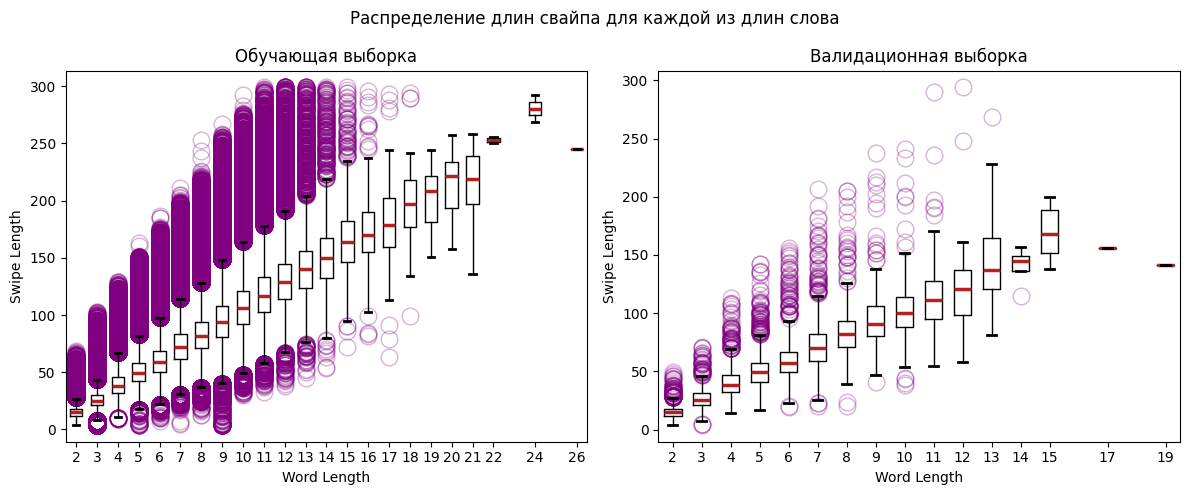

In [55]:
boxplots = box_plot_word_len_to_swipe_len_lst(
    [train_word_len_to_swipe_lens, val_word_len_to_swipe_len],
    ['Обучающая выборка', 'Валидационная выборка']
)

In [56]:
train_word_len_to_allowed_swipe_len_range = {}
train_word_lens = sorted(train_word_len_prcntg.keys())

train_caps = boxplots[0]['caps']

for i, train_word_len in enumerate(train_word_lens):
    swipe_len_range = (train_caps[2*i].get_ydata()[0], train_caps[2*i+1].get_ydata()[0])
    train_word_len_to_allowed_swipe_len_range[train_word_len] = swipe_len_range

In [57]:
val_word_len_to_allowed_swipe_len_range = {}
val_word_lens = sorted(val_word_len_prcntg.keys())

val_caps = boxplots[1]['caps']

for i, val_word_len in enumerate(val_word_lens):
    swipe_len_range = (val_caps[2*i].get_ydata()[0], val_caps[2*i+1].get_ydata()[0])
    val_word_len_to_allowed_swipe_len_range[val_word_len] = swipe_len_range

In [58]:
val_word_len_to_allowed_swipe_len_range

{2: (4, 27),
 3: (7, 46),
 4: (14, 69),
 5: (17, 81),
 6: (23, 93),
 7: (25, 115),
 8: (39, 126),
 9: (47, 138),
 10: (54, 152),
 11: (55, 171),
 12: (58, 161),
 13: (81, 228),
 14: (136.0, 157),
 15: (138, 200),
 17: (156, 156),
 19: (141, 141)}

In [59]:
train_word_len_to_allowed_swipe_len_range

{2: (4, 27),
 3: (8, 43),
 4: (11, 67),
 5: (18, 82),
 6: (22, 97),
 7: (31, 114),
 8: (37, 128),
 9: (41, 148),
 10: (49, 164),
 11: (58, 178),
 12: (68, 191),
 13: (76, 204),
 14: (80, 219),
 15: (95, 235),
 16: (103, 237),
 17: (113, 244),
 18: (134, 242),
 19: (151, 244),
 20: (158, 257),
 21: (136, 258),
 22: (250, 256),
 24: (269, 292),
 26: (245, 245)}

чем искать корреляцию между длиной слова и 
   числом точек кривой корректнее искать корреляцию между длиной ломаной, 
   проходящей через центры клавиш таргетного слова и длиной тракетории свайпа 
   (не число точек, а сумма расстояний между ними)

In [60]:
def get_word_len_to_swipe_lens(dataset_path: str, total: Optional[int] = None) -> Dict[int, List[int]]:
    """Given a path to dataset returns a dictionary where keys are word lengths and values are lists of swipe lengths"""
    word_len_to_swipe_len = defaultdict(list)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            word = line_data['word']
            swipe_len = len(line_data['curve']['x'])
            word_len_to_swipe_len[len(word)].append(swipe_len)
    return word_len_to_swipe_len

In [61]:
from typing import Tuple

class WordCentersDistanceGetter:
    """
    Given a word and a gridname returns a sum
    of distances between centers of keys corresponding
    to characters in the word.
    """

    def __init__(self, grid_path: str,
                 gname_to_char_substitutes: Dict[str, Dict[str, str]]) -> None:
        with open(grid_path, encoding="utf-8") as f:
            self.gridname_to_grid = json.load(f)
        
        self.gname_to_key_coords = self._get_gname_to_key_coords()

        self.gname_to_char_subs = gname_to_char_substitutes
    
    def _get_key_label(self, key: dict) -> str:
        if 'label' in key:
            return key['label']
        if 'action' in key:
            return key['action']
        raise ValueError("Key has no label or action property")
    
    def _get_key_center(self, hitbox: Dict[str, int]) -> Tuple[float, float]:
        x = hitbox['x'] + hitbox['w'] / 2
        y = hitbox['y'] + hitbox['h'] / 2
        return x, y

    
    def _get_gname_to_key_coords(self, 
                                  ) -> Dict[str, Dict[str, Tuple[int, int]]]:
        gname_to_char_coords = {}
        for gname, grid in self.gridname_to_grid.items():
            keys = grid['keys']
            gname_to_char_coords[gname] = {
                self._get_key_label(key): self._get_key_center(key['hitbox'])
                for key in keys
            }

        return gname_to_char_coords
    
    def _substitute_chars(self, word: str, gname) -> str:
        for old_char, new_char in self.gname_to_char_subs[gname].items():
            word = word.replace(old_char, new_char)
        return word
    

    def _get_dist(self, char1: str, char2: str, key_coords: Dict[str, Tuple[int, int]]) -> float:
        x1, y1 = key_coords[char1]
        x2, y2 = key_coords[char2]
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    
    

    def __call__(self, word: str, gridname: str) -> float:
        key_coords = self.gname_to_key_coords[gridname]
        word = self._substitute_chars(word, gridname)

        dist = 0
        for i in range(len(word) - 1):
            dist += self._get_dist(word[i], word[i+1], key_coords)
        return dist
    


class CurveDistanceGetter:
    """
    Given a curve dict that has x and y properties returns a sum
    of distances between consecutive points in the curve.
    """

    def __call__(self, curve: Dict[str, List[float]]) -> float:
        x = curve['x']
        y = curve['y']

        dist = 0
        for i in range(len(x) - 1):
            dist += ((x[i] - x[i+1]) ** 2 + (y[i] - y[i+1]) ** 2) ** 0.5
        return dist

In [62]:
def get_word_line_len_to_swipe_lens(dataset_path: str, 
                               word_centers_dist_getter: WordCentersDistanceGetter,
                               curve_dist_getter: CurveDistanceGetter,
                               total: Optional[int] = None,
                               ) -> Dict[int, List[int]]:
    """
    Given a path to dataset returns a dictionary where keys are word lengths
    and values are lists of swipe lengths. Also takes a WordCentersDistanceGetter
    instance and a CurveDistanceGetter instance to calculate distances between
    centers of keys and between consecutive points in the curve respectively.
    """
    word_line_len_to_swipe_len = defaultdict(list)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            word = line_data['word']
            curve = line_data['curve']
            gridname = curve['grid_name']
            word_line_len = word_centers_dist_getter(word, gridname)
            curve_len = curve_dist_getter(curve)
            word_line_len_to_swipe_len[round(word_line_len)].append(round(curve_len))
    return word_line_len_to_swipe_len

In [63]:
gname_to_char_subs = {
    'default': {'ё': 'е', '-': '', 'ъ': ''},
    'extra': {'-': '', 'ъ': ''}
}

word_centers_dist_getter = WordCentersDistanceGetter(GRIDS_PATH, 
                                                     gname_to_char_subs)
curve_dist_getter = CurveDistanceGetter()

train_word_line_len_to_swipe_len = get_word_line_len_to_swipe_lens(TRAIN_DATASET_PATH,
                                                                     word_centers_dist_getter,
                                                                     curve_dist_getter,
                                                                     total = 6_000_000)

val_word_line_len_to_swipe_len = get_word_line_len_to_swipe_lens(VALID_DATASET_PATH,
                                                                    word_centers_dist_getter,
                                                                    curve_dist_getter,
                                                                    total = 10_000)


100%|██████████| 10000/10000 [00:00<00:00, 12807.59it/s]


In [64]:
def plot_word_line_len_to_swipe_len_lst(word_line_len_to_swipe_len_lst: List[Dict[int, List[int]]],
                                        titles: Optional[List[str]] = None) -> None:
    if titles is None:
        titles = ['' for _ in word_line_len_to_swipe_len_lst]
    assert len(titles) == len(word_line_len_to_swipe_len_lst)

    fig, axs = plt.subplots(nrows=1, ncols=len(word_line_len_to_swipe_len_lst))
    if len(word_line_len_to_swipe_len_lst) == 1:
        axs = [axs]
    fig.set_figwidth(12)
    fig.set_figheight(5)
    fig.suptitle('Распределение длин свайпа для каждой из длин ломаной, проходящей через центры клавиш, соответствующих буквам слова')

    for i, (word_line_len_to_swipe_len, title) in enumerate(zip(word_line_len_to_swipe_len_lst, titles)):
        for word_line_len, swipe_lens in word_line_len_to_swipe_len.items():
            axs[i].scatter([word_line_len] * len(swipe_lens), swipe_lens, alpha=0.1)
        axs[i].set_xlabel('Word line length')
        axs[i].set_ylabel('Swipe length')
        axs[i].set_title(title)

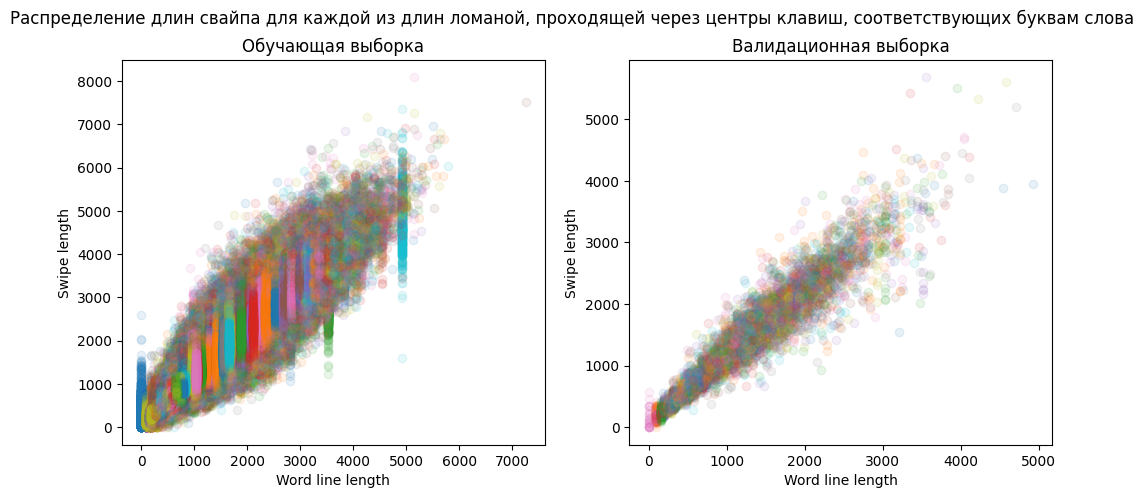

In [65]:
plot_word_line_len_to_swipe_len_lst(
    [train_word_line_len_to_swipe_len, val_word_line_len_to_swipe_len],
    ['Обучающая выборка', 'Валидационная выборка']
)

In [66]:
def box_plot_word_line_len_to_swipe_len_lst(word_line_len_to_swipe_len_lst: List[Dict[int, List[int]]],
                                        titles: Optional[List[str]] = None) -> None:
    if titles is None:
        titles = ['' for _ in word_line_len_to_swipe_len_lst]
    assert len(titles) == len(word_line_len_to_swipe_len_lst)

    fig, axs = plt.subplots(nrows=1, ncols=len(word_line_len_to_swipe_len_lst))
    if len(word_line_len_to_swipe_len_lst) == 1:
        axs = [axs]
    fig.set_figwidth(12)
    fig.set_figheight(5)
    fig.suptitle('Распределение длин свайпа для каждой из длин ломаной, проходящей через центры клавиш, соответствующих буквам слова')

    for i, (word_line_len_to_swipe_len, title) in enumerate(zip(word_line_len_to_swipe_len_lst, titles)):
        word_line_lens = sorted(word_line_len_to_swipe_len.keys())
        swipe_lens = [word_line_len_to_swipe_len[word_line_len] for word_line_len in word_line_lens]

        axs[i].boxplot(swipe_lens, positions=word_line_lens, widths=0.6)
        axs[i].set_xlabel('Word line length')
        axs[i].set_ylabel('Swipe length')
        axs[i].set_title(title)
        axs[i].set_xticks(word_line_lens)
    
    plt.tight_layout()
    plt.show()

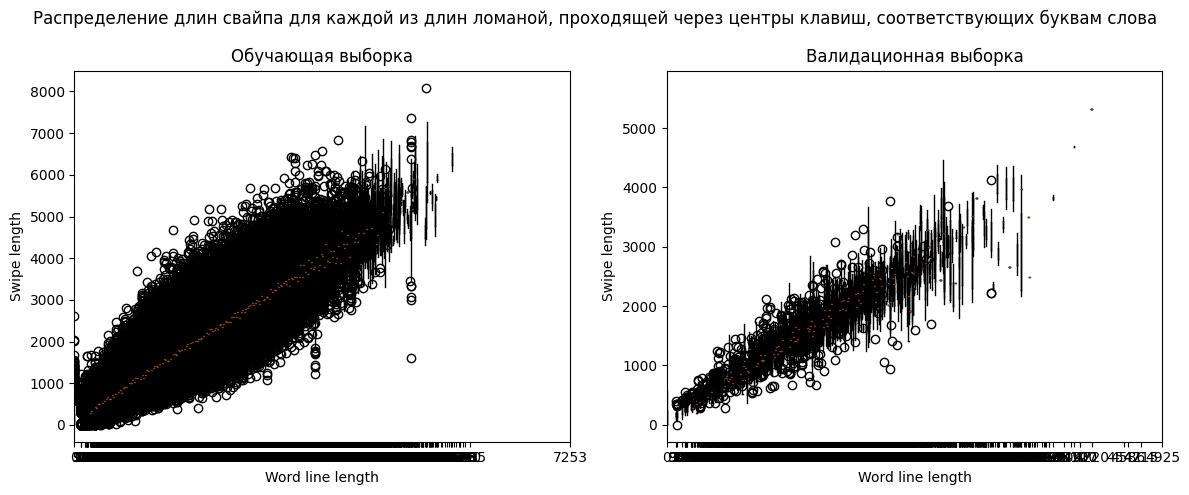

In [67]:
box_plot_word_line_len_to_swipe_len_lst(
    [train_word_line_len_to_swipe_len, val_word_line_len_to_swipe_len],
    ['Обучающая выборка', 'Валидационная выборка']
)

In [68]:
def group_word_line_lens(word_line_len_to_swipe_len: Dict[int, List[int]], 
                         bin_size: int) -> Dict[int, List[int]]:
    grouped_data = defaultdict(list)
    for word_line_len, swipe_lens in word_line_len_to_swipe_len.items():
        bin_idx = word_line_len // bin_size
        grouped_data[bin_idx].extend(swipe_lens)
    return grouped_data


def box_plot_word_line_len_to_swipe_len_lst_grouped(
                                    word_line_len_to_swipe_len_lst: List[Dict[int, List[int]]],
                                    titles: Optional[List[str]] = None,
                                    bin_size: int = 10) -> None:
    if titles is None:
        titles = ['' for _ in word_line_len_to_swipe_len_lst]
    assert len(titles) == len(word_line_len_to_swipe_len_lst)

    word_line_len_to_swipe_len_grouped_lst = [
        group_word_line_lens(word_line_len_to_swipe_len, bin_size)
        for word_line_len_to_swipe_len in word_line_len_to_swipe_len_lst
    ]

    
    fig, axs = plt.subplots(nrows=1, ncols=len(word_line_len_to_swipe_len_lst))
    if len(word_line_len_to_swipe_len_lst) == 1:
        axs = [axs]
    fig.set_figwidth(12)
    fig.set_figheight(5)
    fig.suptitle('Распределение длин свайпа для каждой из длин ломаной, проходящей через центры клавиш, соответствующих буквам слова')

    for i, (word_line_len_to_swipe_len_grouped, title) in enumerate(zip(word_line_len_to_swipe_len_grouped_lst, titles)):
        word_line_lens = sorted(word_line_len_to_swipe_len_grouped.keys())
        swipe_lens = [word_line_len_to_swipe_len_grouped[word_line_len] for word_line_len in word_line_lens]

        axs[i].boxplot(swipe_lens, positions=word_line_lens, widths=0.6,
                          medianprops=dict(linestyle='-', linewidth=2.5, color='firebrick'),
                          flierprops=dict(marker='o', markersize=2, markeredgecolor='purple',
                                        alpha=0.3, zorder=1),
                          whiskerprops=dict(zorder=10,),
                          capprops=dict(zorder=10, linewidth=2))
        axs[i].set_xlabel('Word line length')
        axs[i].set_ylabel('Swipe length')
        axs[i].set_title(title)
        axs[i].set_xticks(word_line_lens)

    plt.tight_layout()

    plt.show()

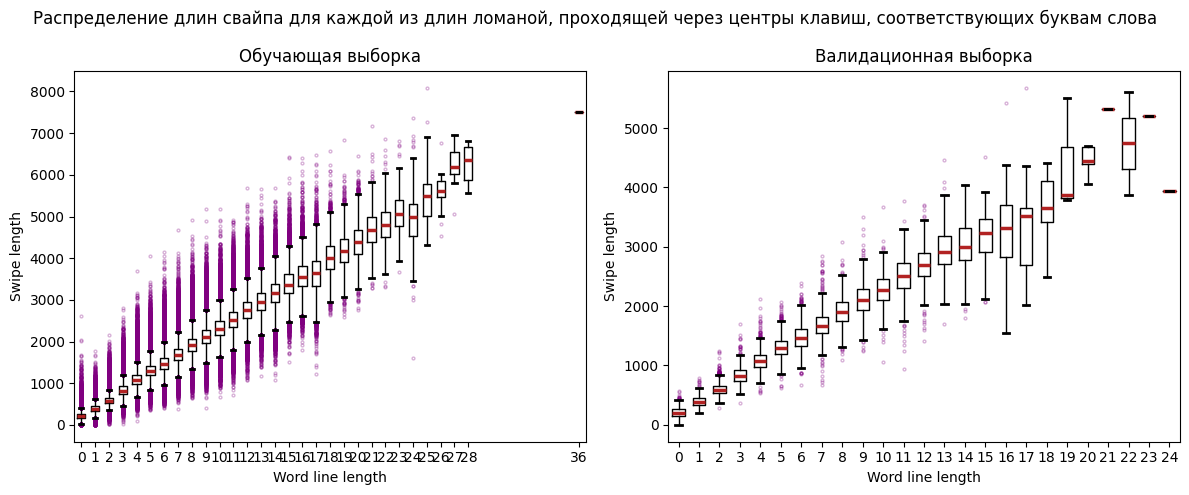

In [69]:
box_plot_word_line_len_to_swipe_len_lst_grouped(
    [train_word_line_len_to_swipe_len, val_word_line_len_to_swipe_len],
    ['Обучающая выборка', 'Валидационная выборка'],
    bin_size = 200
)

# Посмотрим, как работает алгоритм get_segments

`get_segments` is the "SEGMENTS" algorithm from the "Modeling Gesture Typing Movements" paper 
(https://doi.org/10.1080/07370024.2016.1215922).   


It partitions the swipe into segments aligned with key transitions in the target word.

`segments[i]` is a partition of the swipe that relates to the i-th 
charracter in the target word (after collapsing consecutive duplicates).

In this alorithm consecutve points of the swipe belong to current key until
1. Movement brings the gesture closer to the next key AND
2. The gesture is no longer approaching the current key

In [70]:
### 
# Add parent directory to sys.path to import scripts from the root directory
import sys; sys.path.append('..')
###

from grid_processing_utils import get_label_to_key_map, get_key_centers
from data_analysis.get_segments import get_segments

In [71]:
grids_path = "../../data/data_preprocessed/gridname_to_grid.json"
with open(grids_path , encoding="utf-8") as f:
    grids = json.load(f)

In [72]:
gridname_to_label_to_key = {
    gridname: get_label_to_key_map(grid['keys'], copy_keys=False)
    for gridname, grid in grids.items()
}

In [73]:
data = json.loads('{"word":"ее","curve":{"x":[437,437,434,433,433],"y":[60,60,60,59,59],"t":[0,7,76,461,503],"grid_name":"default"}}')

curve = data['curve']


key_centers = get_key_centers(target_word=data['word'], 
                              label_to_key=gridname_to_label_to_key[curve['grid_name']], 
                              absent_chars_on_keyboard='-')
segments = get_segments(key_centers, curve['x'], curve['y'])

segments, data['word']

([[(437, 60), (437, 60), (434, 60), (433, 59), (433, 59)]], 'ее')

In [74]:
from typing import List
import json

from tqdm import tqdm


valid_data_list: List[dict] = []

with open(VALID_DATASET_PATH, encoding="utf-8") as f:
    for line in tqdm(f):
        valid_data_list.append(json.loads(line))

10000it [00:00, 24333.02it/s]


In [75]:
data = valid_data_list[1]
curve = data['curve']
key_centers = get_key_centers(target_word=data['word'], 
                              label_to_key=gridname_to_label_to_key[curve['grid_name']], 
                              absent_chars_on_keyboard='-')
segments = get_segments(key_centers, curve['x'], curve['y'])

In [76]:
print(data['word'])

все


In [77]:
sum(len(s) for s in segments), len(curve['x'])

(27, 27)

In [78]:
len(segments), len(data['word'])

(3, 3)

In [79]:
print(list(zip(curve['x'], curve['y'])))
print(segments)

[(228, 246), (228, 246), (228, 246), (228, 246), (229, 247), (230, 247), (234, 250), (255, 267), (295, 308), (331, 350), (351, 373), (360, 384), (365, 388), (369, 388), (373, 386), (377, 379), (384, 362), (395, 330), (409, 285), (427, 231), (444, 175), (459, 127), (470, 87), (478, 56), (482, 34), (483, 19), (483, 19)]
[[(228, 246), (228, 246), (228, 246), (228, 246), (229, 247), (230, 247), (234, 250), (255, 267), (295, 308)], [(331, 350), (351, 373), (360, 384), (365, 388), (369, 388), (373, 386), (377, 379), (384, 362), (395, 330), (409, 285)], [(427, 231), (444, 175), (459, 127), (470, 87), (478, 56), (482, 34), (483, 19), (483, 19)]]


In [80]:
import sys; import os; sys.path.insert(1, os.path.join(os.getcwd(), ".."))


from yandex_baseline_scripts.viz import plot_keyboard
from grid_processing_utils import get_grid, get_wh

import numpy as np
import matplotlib.pyplot as plt

In [81]:
def data_to_segments(data: dict, gridname_to_label_to_key: dict) -> List[List[int]]:
    curve = data['curve']
    key_centers = get_key_centers(target_word=data['word'], 
                                  label_to_key=gridname_to_label_to_key[curve['grid_name']],
                                  absent_chars_on_keyboard='-')
    return get_segments(key_centers, curve['x'], curve['y'])

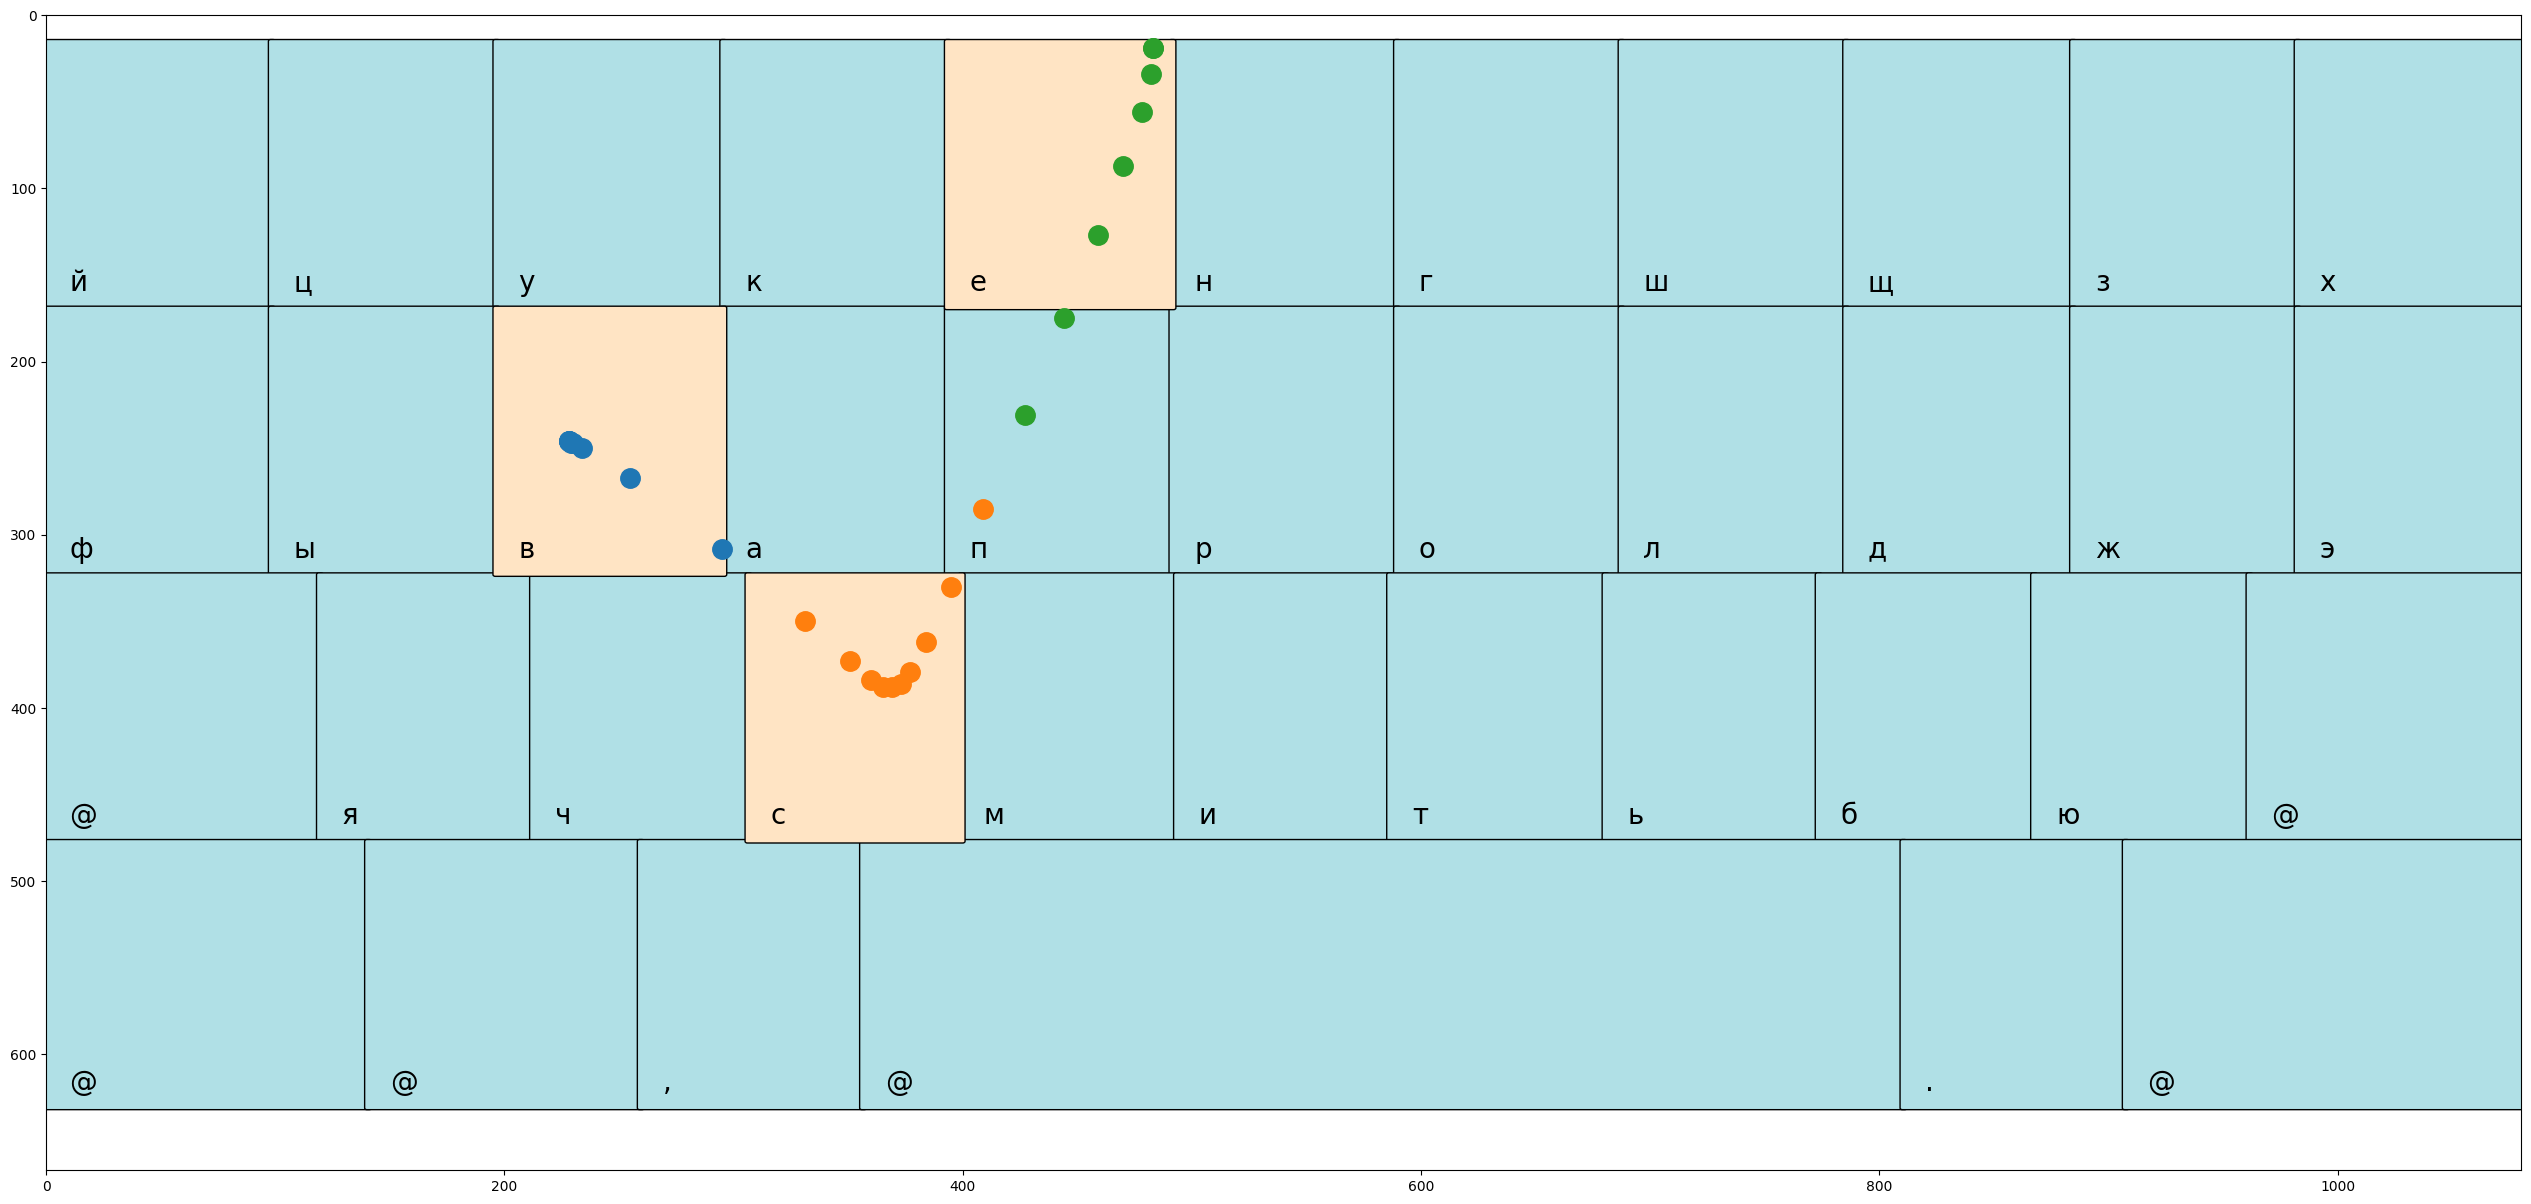

все


In [82]:
DATA_INDEX = 1


data = valid_data_list[DATA_INDEX]
segments = data_to_segments(data, gridname_to_label_to_key)


grid = get_grid(data['curve']['grid_name'], GRIDS_PATH)
width, height = get_wh(grid)


fig, ax = plot_keyboard(grid, word = data['word'])

for segment in segments:
    segment = np.array(segment)
    ax.plot(segment[:, 0], segment[:, 1], 'o', markersize=14)


ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plt.show()
print(data['word'])

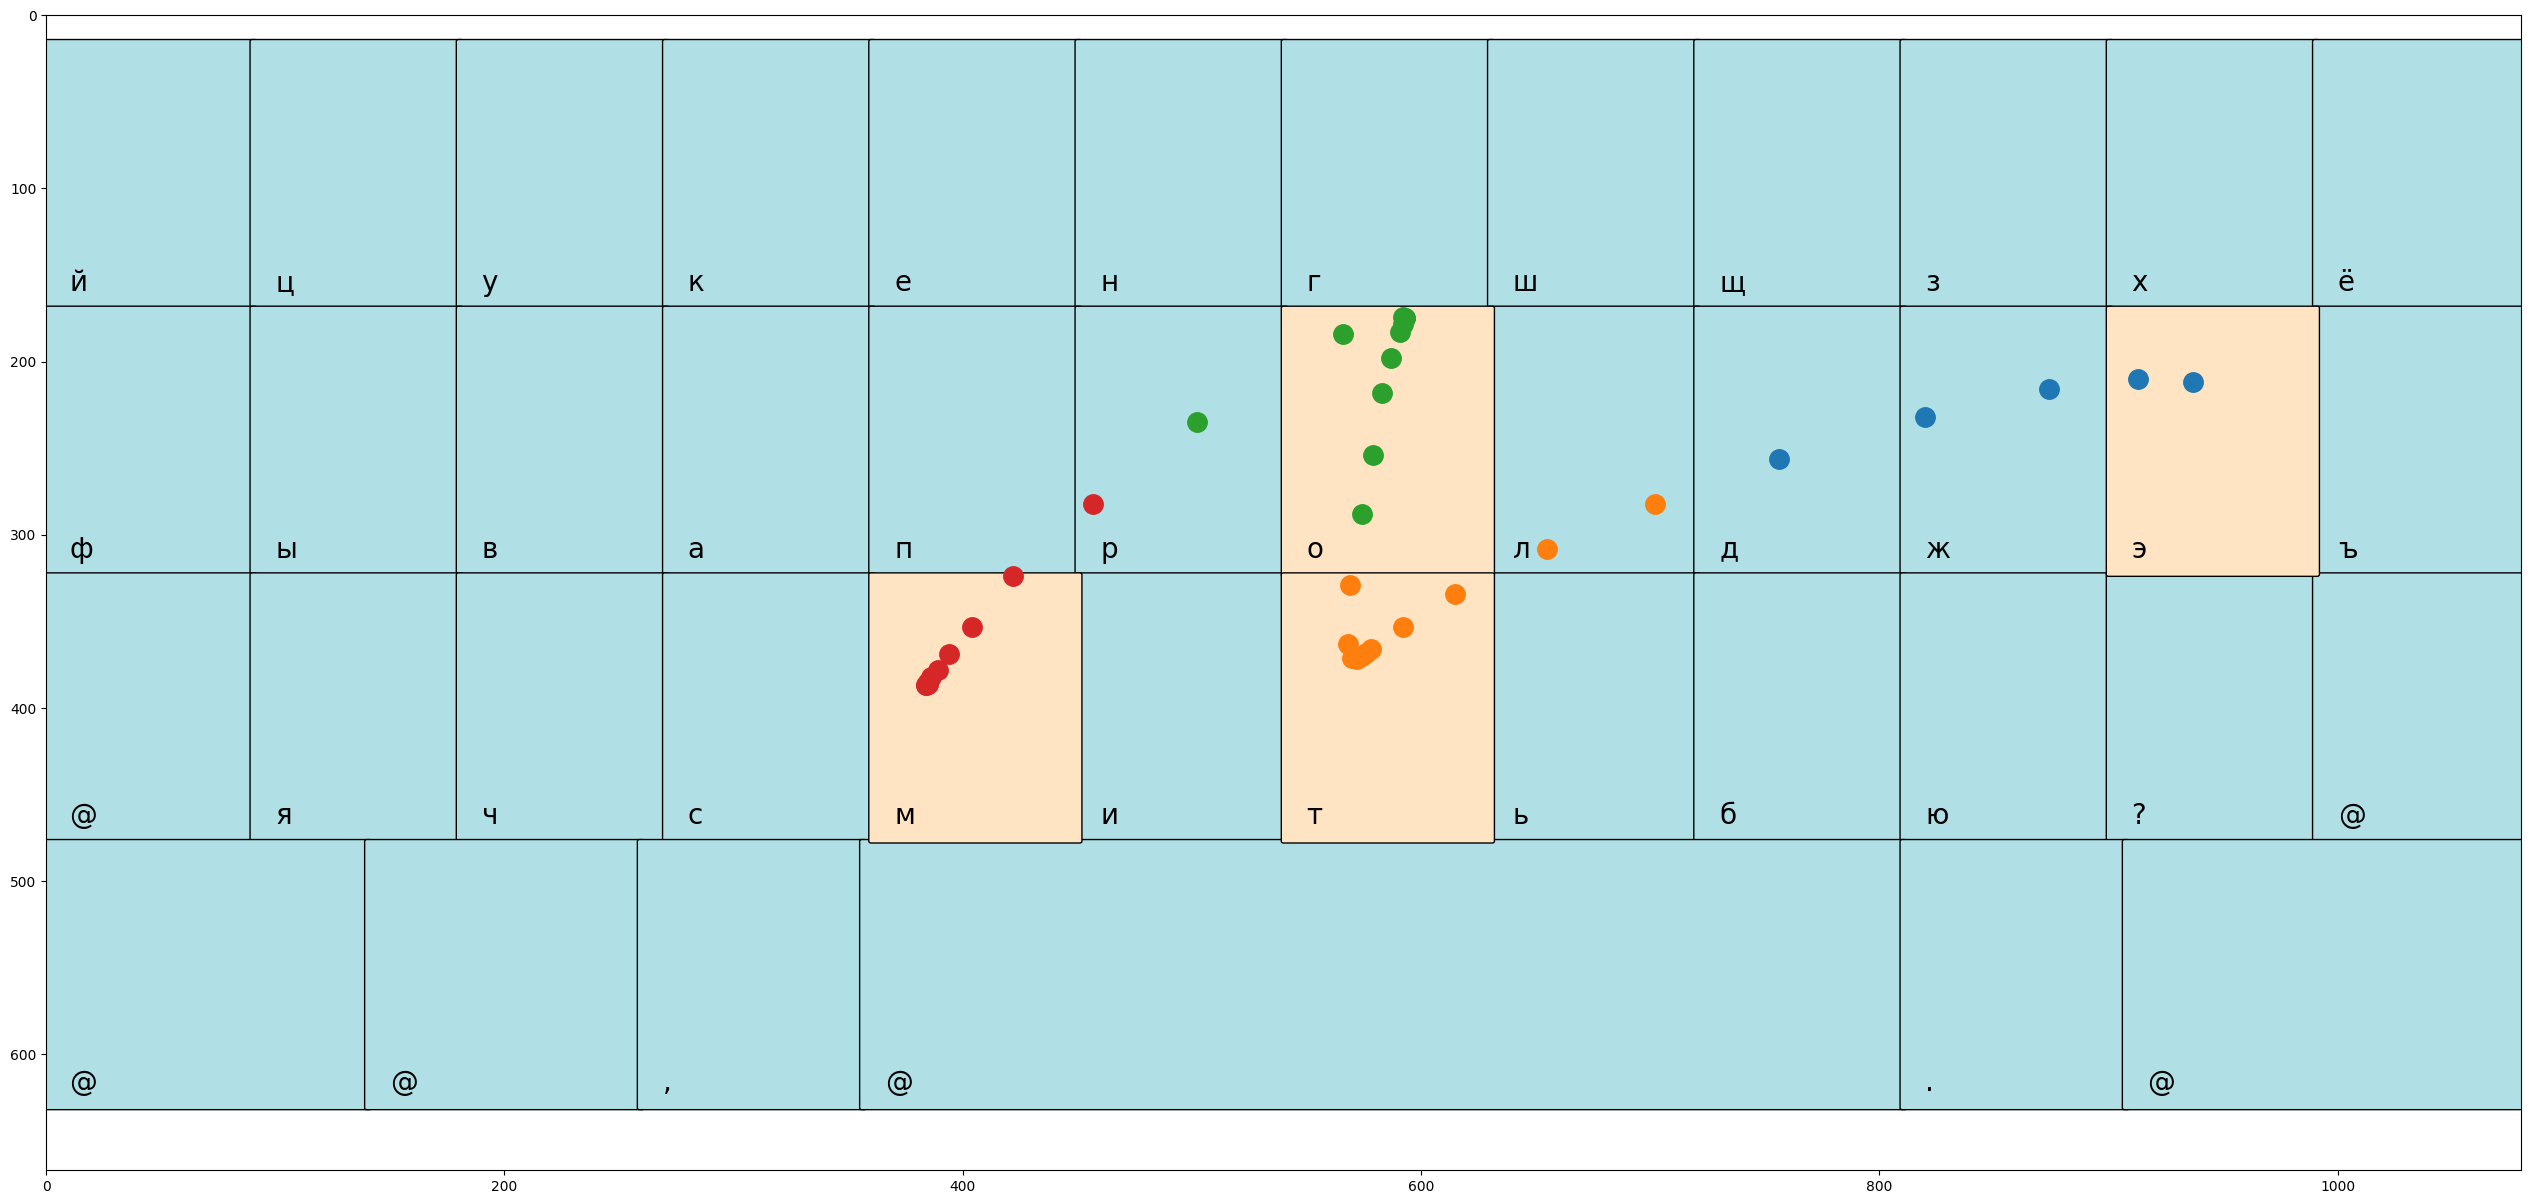

этом


In [83]:
DATA_INDEX = 2


data = valid_data_list[DATA_INDEX]
segments = data_to_segments(data, gridname_to_label_to_key)


grid = get_grid(data['curve']['grid_name'], GRIDS_PATH)
width, height = get_wh(grid)


fig, ax = plot_keyboard(grid, word = data['word'])

for segment in segments:
    segment = np.array(segment)
    ax.plot(segment[:, 0], segment[:, 1], 'o', markersize=14)


ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plt.show()
print(data['word'])

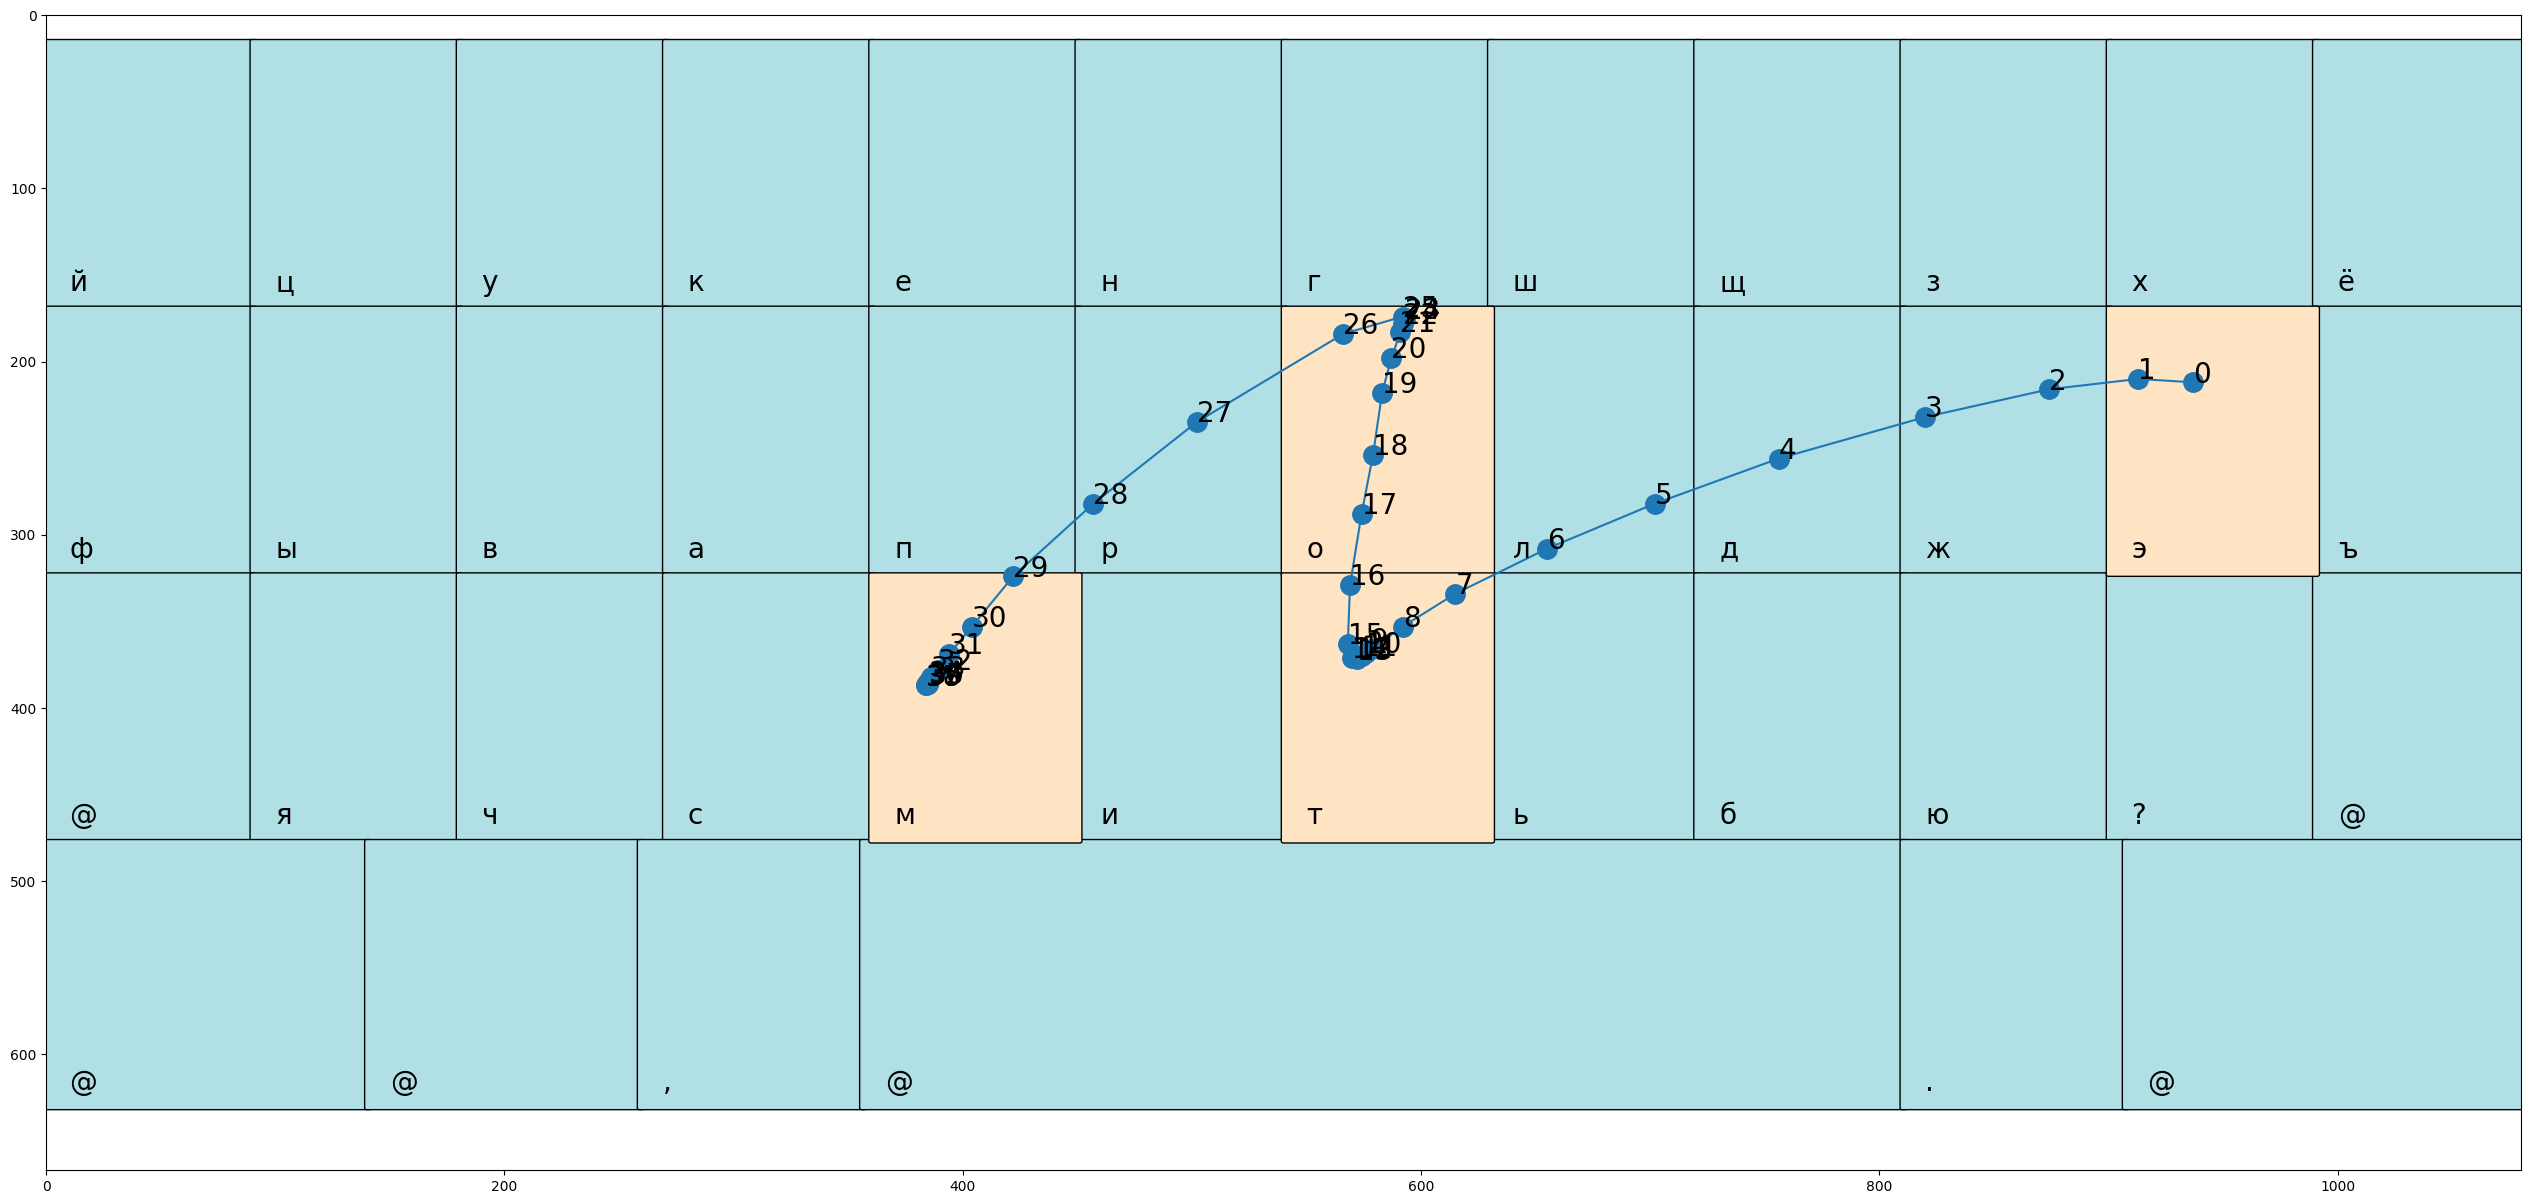

In [84]:
fig, ax = plot_keyboard(grid, word = data['word'])


# ax.scatter(c['x'], c['y'])
ax.plot(data['curve']['x'], data['curve']['y'], '-o', markersize=14)
for i, (x, y) in enumerate(zip(data['curve']['x'], data['curve']['y'])):
    ax.text(x,y,i, fontsize=20)

ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plt.show()

In [85]:
from grid_processing_utils import distance, get_kb_key_center

label2key_default = get_label_to_key_map(grids['default']['keys'])
max_dist  = distance(*get_kb_key_center(label2key_default['ф']['hitbox']),
         *get_kb_key_center(label2key_default['ц']['hitbox'])
)
max_dist

182.53766734567415

In [86]:
get_kb_key_center(label2key_default['й']['hitbox'])

(49.5, 92.0)

In [87]:
get_kb_key_center(label2key_default['ф']['hitbox'])

(49.5, 246.0)

In [88]:
get_kb_key_center(label2key_default['ц']['hitbox'])

(147.5, 92.0)

In [89]:
grids['default']['height'], grids['default']['width']

(667, 1080)

# Let's look at the errors 

Let's look at the errors that were filtered out in `data_obtaining_and_preprocessing\filter_dataset.py`

In [90]:
INSUFFICIENT_POINTS_IN_SEGMENT_PATH = "../../data/errors_in_original_data_swipes/insufficient_points_in_segment.txt"
NON_MONOTONIC_TIME_PATH = "../../data/errors_in_original_data_swipes/non_monotonic_timestamps.txt"
POINTS_TOO_FAR_PATH = "../../data/errors_in_original_data_swipes/points_too_far.txt"

In [91]:
def read_indexes_from_file(file_path: str) -> List[int]:
    indexes = []
    with open(file_path, 'r') as f:
        for line in f:
            indexes.append(int(line.strip()))
    return indexes

In [92]:
insufficient_points_in_segment_indexes = read_indexes_from_file(INSUFFICIENT_POINTS_IN_SEGMENT_PATH)
non_monotonic_time_indexes = read_indexes_from_file(NON_MONOTONIC_TIME_PATH)
points_too_far_indexes = read_indexes_from_file(POINTS_TOO_FAR_PATH)

In [93]:
errors_num = sum(
    [len(insufficient_points_in_segment_indexes), 
     len(non_monotonic_time_indexes), 
     len(points_too_far_indexes)])
errors_num

415196

In [94]:
print(errors_num/6_000_000*100)

6.919933333333334


In [95]:
# default only errors:
# errors_num = 388756, errors_percentage = 6.91 %

# extra only errors:
# errors_num = 24488, errors_percentage = 6.55 %